In [5]:
import pandas as pd
import numpy as np
import warnings
import itertools
from math import sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import datetime
import time

import streamlit as st
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore") # specify to ignore warning messages


%matplotlib inline
plt.rcParams['figure.figsize']=(15,6) # set the figure size
plt.rcParams['lines.linewidth'] = 1
# plt.style.use('fivethirtyeight') # using the fivethirtyeight matplotlib theme

In [ ]:
pip install pmdarima

In [ ]:
pip install streamlit

In [7]:
cols = ['obs', 'year', 'month', 'day', 'date', 'sea_surface_temp']
df = pd.read_excel("elnino.xlsx", header=0, skiprows=0, names=cols)
df.dropna()

# List all fields in the dataframe
print("Columns: {}".format(df.columns.tolist()))

Columns: ['obs', 'year', 'month', 'day', 'date', 'sea_surface_temp']


In [8]:
df

,obs,year,month,day,date,sea_surface_temp
0,145211,93,1,1,930101,27.37
1,145212,93,1,2,930102,27.29
2,145213,93,1,3,930103,27.15
3,145214,93,1,4,930104,27.17
4,145215,93,1,5,930105,27.22
...,...,...,...,...,...,...
1456,146667,96,12,27,961227,26.82
1457,146668,96,12,28,961228,26.86
1458,146669,96,12,29,961229,26.87
1459,146670,96,12,30,961230,26.91


In [9]:
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')

df.drop(['obs', 'year', 'month', 'day'], axis=1, inplace=True)

In [10]:
df

,date,sea_surface_temp
0,1993-01-01,27.37
1,1993-01-02,27.29
2,1993-01-03,27.15
3,1993-01-04,27.17
4,1993-01-05,27.22
...,...,...
1456,1996-12-27,26.82
1457,1996-12-28,26.86
1458,1996-12-29,26.87
1459,1996-12-30,26.91


In [11]:
print("\nStart date : {}\nEnd date   : {}".\
      format(df['date'].min(), df['date'].max()))


Start date : 1993-01-01 00:00:00
End date   : 1996-12-31 00:00:00


In [12]:
# Setting index for time-series data
df = df.set_index('date')

In [13]:
df

,sea_surface_temp
date,
1993-01-01,27.37
1993-01-02,27.29
1993-01-03,27.15
1993-01-04,27.17
1993-01-05,27.22
...,...
1996-12-27,26.82
1996-12-28,26.86
1996-12-29,26.87


In [14]:
df.isnull().sum()

sea_surface_temp    0
dtype: int64

In [15]:
null_count=0

for value in df['sea_surface_temp']:
    if value == '.':
        null_count += 1

print("Null count: {}".format(null_count))


df.loc[df['sea_surface_temp'] == '.', 'sea_surface_temp'] = np.nan

Null count: 22


In [16]:
df = df.apply(pd.to_numeric, errors='coerce').astype('float64')
df['sea_surface_temp'].interpolate(method='linear', inplace=True)

df.isna().sum()

sea_surface_temp    0
dtype: int64

In [17]:
#Weekly Series
series = df.resample('W').mean()
series

,sea_surface_temp
date,
1993-01-03,27.270000
1993-01-10,27.285714
1993-01-17,27.487143
1993-01-24,27.634286
1993-01-31,27.690000
...,...
1996-12-08,27.364286
1996-12-15,27.232857
1996-12-22,27.174286


<Axes: xlabel='date'>

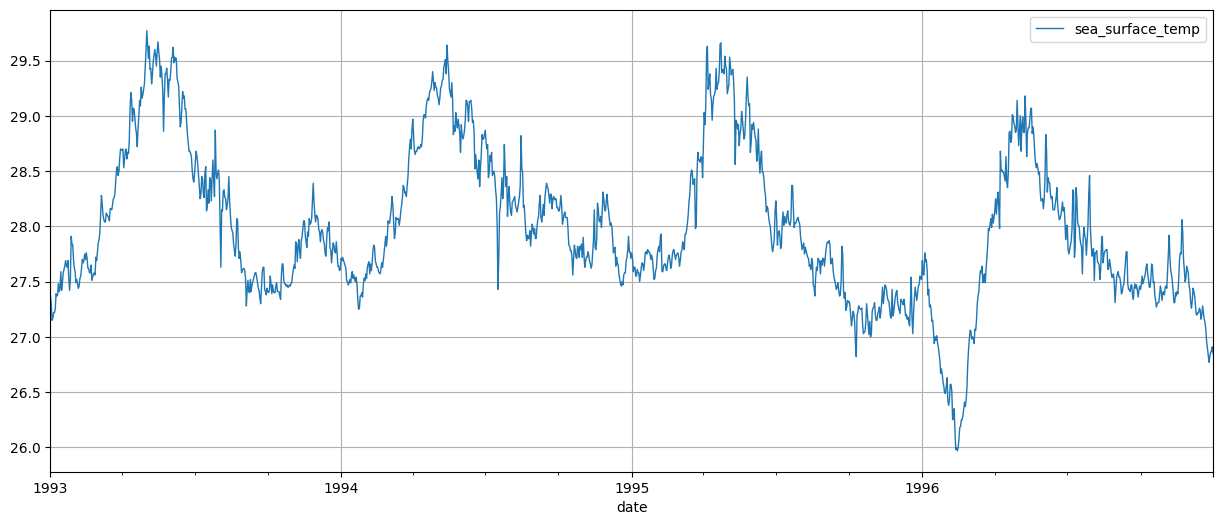

In [18]:
df.plot(grid=True, figsize=(15,6), linewidth=1)

<Axes: xlabel='date'>

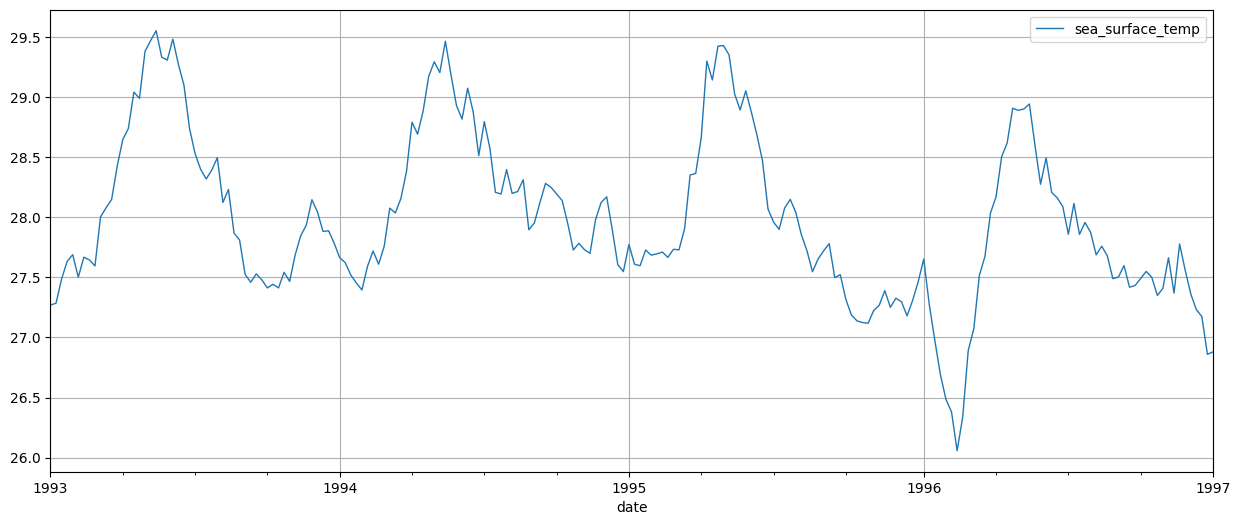

In [19]:
#Weeklt Time Series
series.plot(grid=True, figsize=(15,6), linewidth=1)


In [20]:
decomposition = seasonal_decompose(series, model='additive', period=52)

<Axes: xlabel='date'>

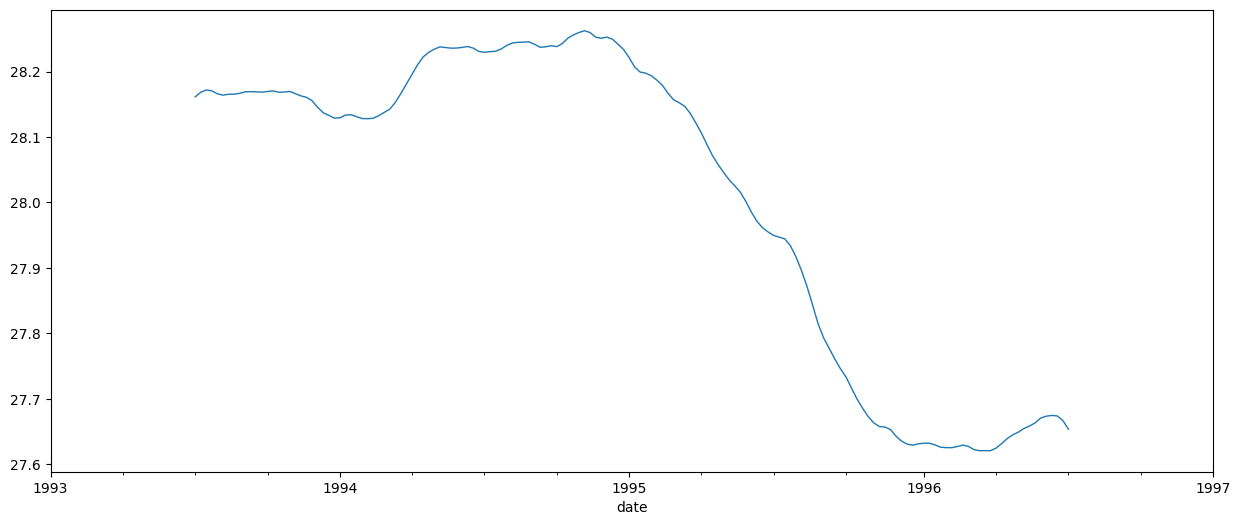

In [21]:
# Trend
decomposition.trend.plot(figsize=(15,6))

<Axes: xlabel='date'>

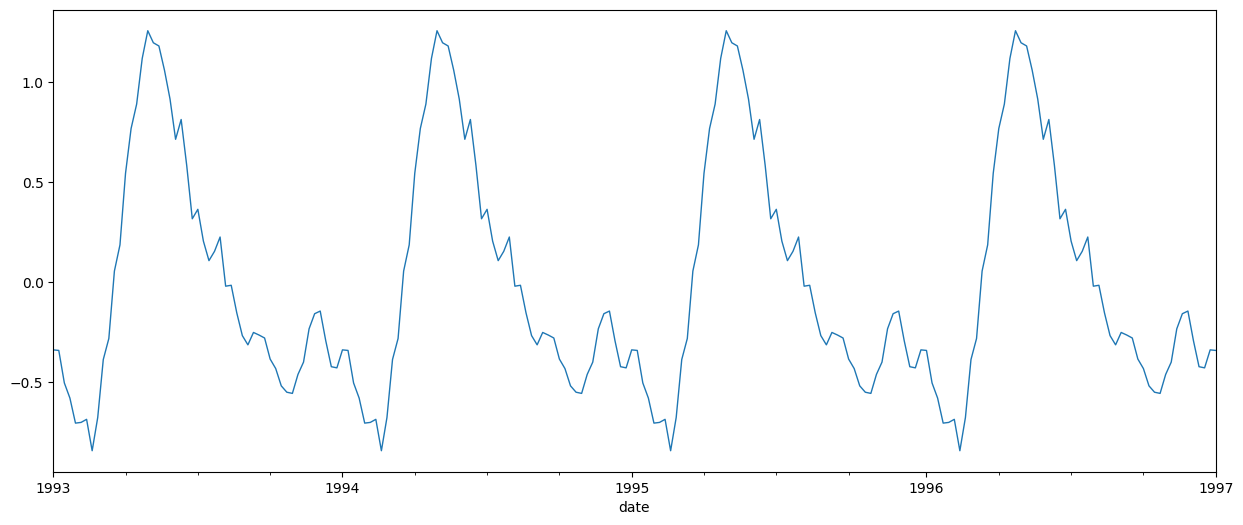

In [22]:
# Seasonal
decomposition.seasonal.plot(figsize=(15,6))

<Axes: xlabel='date'>

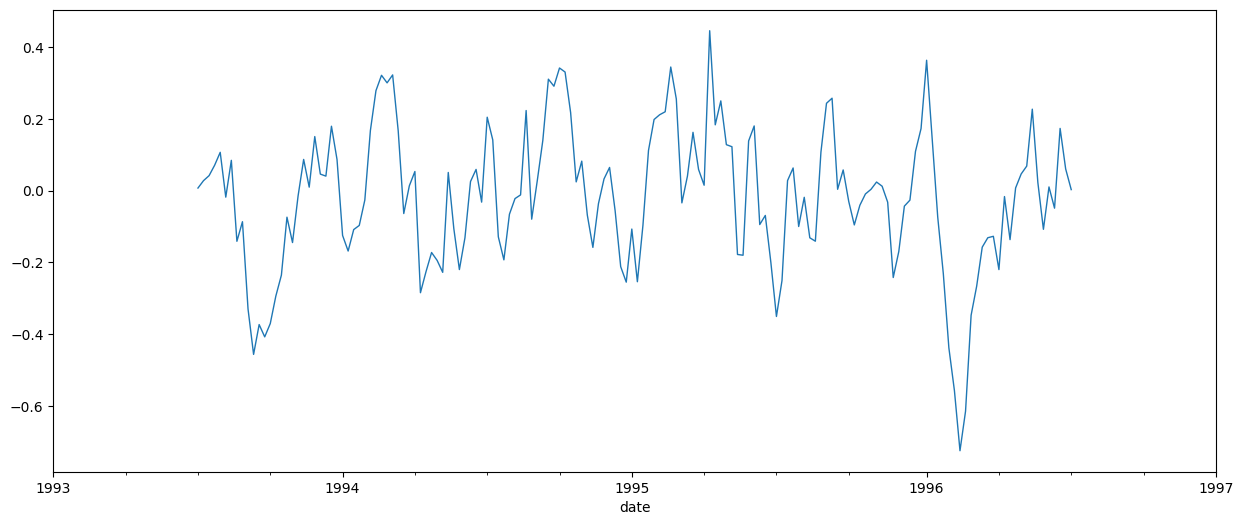

In [23]:
# Residual
decomposition.resid.plot(figsize=(15,6))

<Axes: xlabel='date'>

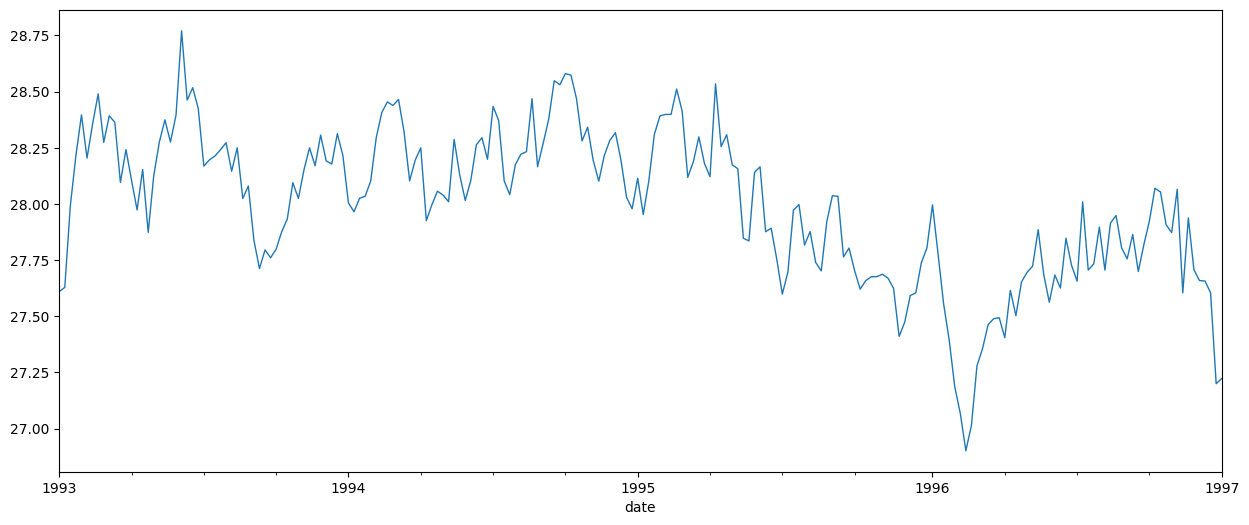

In [24]:
# Plotting time-series without seasonal component

# Simple subtraction works because of additive model
seasonal_adj = decomposition.observed - decomposition.seasonal
seasonal_adj.plot(figsize=(15,6))

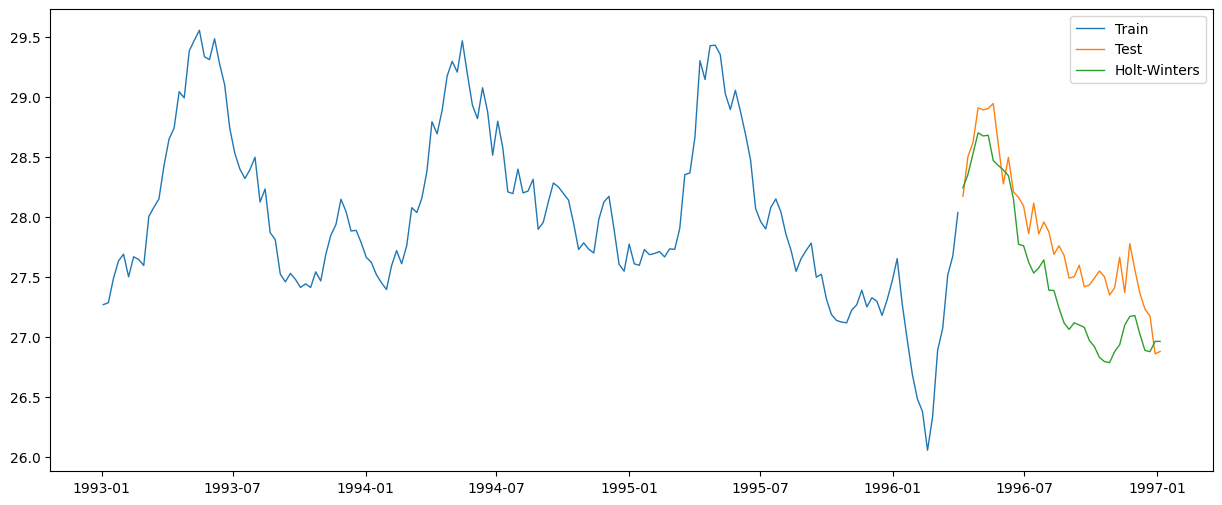

In [25]:
""""
With the model being additive, and seasonality present,
we use Holt-Winters exponential smoothing
"""

# Train-test split (arbitrary)
train, test = series.iloc[:170, 0], series.iloc[170:, 0]

# Create model
model = ExponentialSmoothing(train, freq='W', trend='add', seasonal='add', seasonal_periods=52)
# Fit model
model_fit = model.fit()
# Make prediction
pred = model_fit.predict(start=test.index[0], end=test.index[-1])

# Plot the line graphs
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

In [26]:
rms = sqrt(mean_squared_error(test, pred))
rms

0.4038901839078757

In [27]:
print(f"P-value: {adfuller(series, autolag='AIC')[1]}")

P-value: 0.031176977717016514


In [28]:
#Arima Forecasting
stepwise_model = auto_arima(series, stepwise=True, m=52, trace=True, stationary=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=23.21 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=437.175, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=11.77 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=178.285, Time=2.29 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1997.482, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=222.146, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=180.855, Time=13.30 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=inf, Time=16.94 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=158.833, Time=10.66 sec
 ARIMA(0,0,1)(2,0,0)[52] intercept   : AIC=220.992, Time=36.47 sec
 ARIMA(0,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=36.51 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=327.960, Time=8.99 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=43.003, Time=8.90 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-81.957, Time=0.64 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  210
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 52)   Log Likelihood                  51.796
Date:                              Sat, 18 Nov 2023   AIC                            -91.591
Time:                                      07:29:32   BIC                            -71.509
Sample:                                  01-03-1993   HQIC                           -83.473
                                       - 01-05-1997                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2088      0.453      0.461      0.645      -0.679       1.096
ar.L1          0.9532      0.022     42.715      0.000       0.909       0.997
ar.S.L52       0.6381      0.476      1.340      0.180      -0.295       1.571
ar.S.L104      0.2019      0.171      1.181      0.237      -0.133       0.537
ma.S.L52      -0.5741      0.554     -1.035      0.301      -1.661       0.513
sigma2         0.0322      0.004      7.477      0.000       0.024       0.041
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.59   Prob(JB):                         0.56
Heteroskedasticity (H):               1.32   Skew:                             0.18
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
print(stepwise_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  210
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 52)   Log Likelihood                  51.796
Date:                              Sat, 18 Nov 2023   AIC                            -91.591
Time:                                      07:29:52   BIC                            -71.509
Sample:                                  01-03-1993   HQIC                           -83.473
                                       - 01-05-1997                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2088      0.453      0.461      0.645      -0.679       1.096
ar.L1          0.95

In [30]:
params = stepwise_model.get_params()
params

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 1, 52),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [31]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction = model_fit.predict(start=start, end=end)


In [33]:
 prediction.index = series.index[start:end+1]

In [34]:
print(prediction)

date
1996-04-07    28.065033
1996-04-14    28.247258
1996-04-21    28.490085
1996-04-28    28.647635
1996-05-05    28.596875
1996-05-12    28.769605
1996-05-19    28.527982
1996-05-26    28.361139
1996-06-02    28.292847
1996-06-09    28.429256
1996-06-16    28.240106
1996-06-23    27.883598
1996-06-30    28.046028
1996-07-07    27.862224
1996-07-14    27.607158
1996-07-21    27.617282
1996-07-28    27.769148
1996-08-04    27.550821
1996-08-11    27.564962
1996-08-18    27.562013
1996-08-25    27.265881
1996-09-01    27.271525
1996-09-08    27.390958
1996-09-15    27.485232
1996-09-22    27.457046
1996-09-29    27.384755
1996-10-06    27.336358
1996-10-13    27.189072
1996-10-20    27.049122
1996-10-27    27.077256
1996-11-03    27.084312
1996-11-10    27.090803
1996-11-17    27.319632
1996-11-24    27.439353
1996-12-01    27.466201
1996-12-08    27.242148
1996-12-15    27.019727
1996-12-22    26.977078
1996-12-29    27.137979
1997-01-05    27.031445
Freq: W-SUN, Name: predicted_mean, 

<Axes: xlabel='date'>

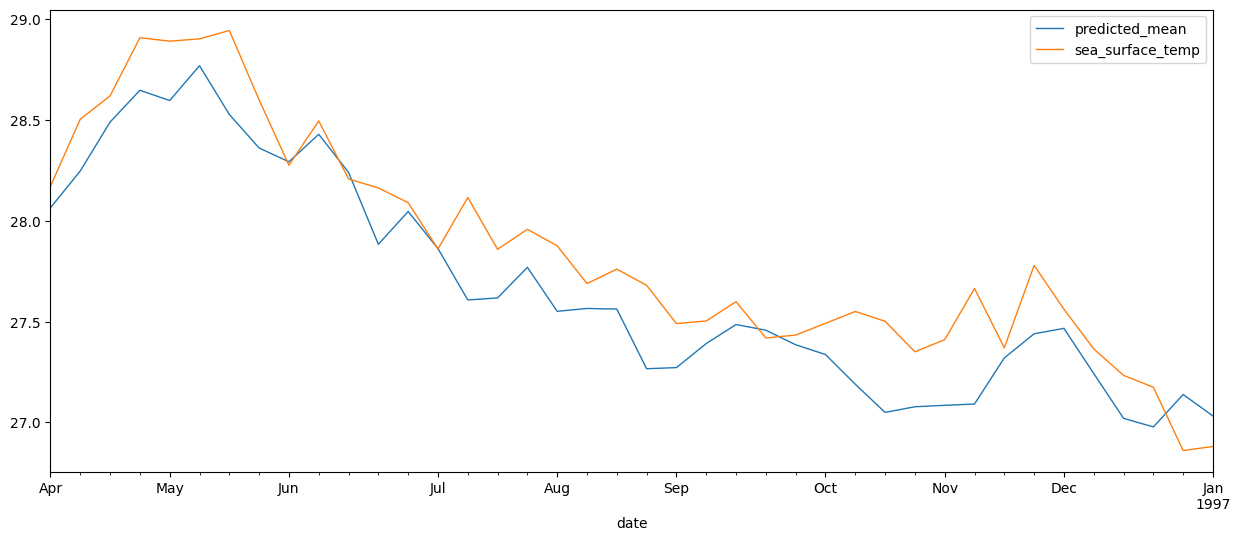

In [32]:
prediction.plot(legend=True)
test.plot(legend=True)

In [35]:
rmse = sqrt(mean_squared_error(test, prediction))
print(f"RMSE: {rmse}")
print(f"Series mean: {series['sea_surface_temp'].mean()}")

RMSE: 0.2518999590064708
Series mean: 27.991914965986396


In [36]:
input_weeks = 50

forecast_model = SARIMAX(series, order=order,
                  seasonal_order=seasonal_order,
                  enforce_stationarity=False, enforce_invertibility=False)

forecast_fit = forecast_model.fit()

forecast = forecast_fit.predict(start=len(series), end=len(series)+input_weeks)
forecast.index = pd.date_range(series.index[-1], periods= input_weeks+1, freq='W')

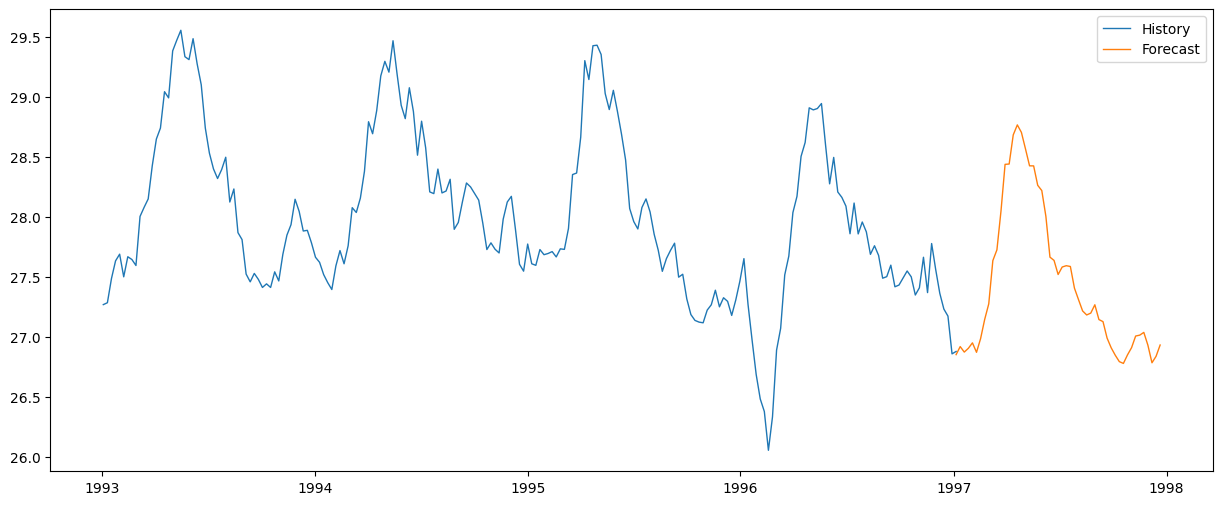

In [37]:
#HOLT WINTERS

plt.plot(series.index, series, label='History')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend(loc='best')